# Libraries Import

In [3]:
import os 
import cv2 
import random
import numpy as np 
import pandas as pd 
from skimage import io
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Exploration and Preprocessing

In [5]:
import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [7]:
walk_through_dir("/content/drive/MyDrive/computer-vision/project/kaggle_3m")

There are 110 directories and 1 images in '/content/drive/MyDrive/computer-vision/project/kaggle_3m'.
There are 0 directories and 74 images in '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_DU_8167_19970402'.
There are 0 directories and 40 images in '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_CS_6667_20011105'.
There are 0 directories and 72 images in '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_FG_6688_20020215'.
There are 0 directories and 64 images in '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_HT_7475_19970918'.
There are 0 directories and 50 images in '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_HT_7684_19950816'.
There are 0 directories and 116 images in '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_DU_7010_19860307'.
There are 0 directories and 72 images in '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_DU_7304_19930325'.
There are 0 directories and 74 image

In [8]:
# getting the directories
dir = []
for dir_ in os.listdir("/content/drive/MyDrive/computer-vision/project/kaggle_3m/"):
  if dir_.split("_")[0] == "TCGA":
    dir.append("/content/drive/MyDrive/computer-vision/project/kaggle_3m/" + dir_)
len(dir)

110

In [9]:
dir[:5]

['/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_DU_8167_19970402',
 '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_CS_6667_20011105',
 '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_FG_6688_20020215',
 '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_HT_7475_19970918',
 '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_HT_7684_19950816']

In [10]:
# Getting the filepaths of all images
file_paths = []
for dir_ in dir:
  for file_path in os.listdir(dir_):
    if len(file_path.split("_")) == 5:
      file_paths.append(dir_ + "/" + file_path)
len(file_paths)

3939

In [11]:
file_paths[:5]

['/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_11.tif',
 '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_1.tif',
 '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_19.tif',
 '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_17.tif',
 '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_16.tif']

In [12]:
# Getting file paths of masked images
file_paths_masked = []
for elem in file_paths:
  file_paths_masked.append(elem.replace(".tif", "_mask.tif"))
len(file_paths_masked)

3939

In [13]:
file_paths_masked[:5]

['/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_11_mask.tif',
 '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_1_mask.tif',
 '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_19_mask.tif',
 '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_17_mask.tif',
 '/content/drive/MyDrive/computer-vision/project/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_16_mask.tif']

### Plotting the original image with corresponding mask

In [14]:
def plot_original_mask():
  plt.figure(figsize=(10, 7))
  # Getting the image
  rand_ = np.random.randint(len(file_paths))
  img = plt.imread(file_paths[rand_])
  img_mask = plt.imread(file_paths_masked[rand_])

  # Plotting the image
  plt.subplot(1, 2, 1)
  plt.imshow(img/255)
  plt.title("Original", color="green")
  plt.axis(False)
  
  plt.subplot(1, 2, 2)
  plt.imshow(img_mask/255)
  plt.title("Masked", color="blue")
  plt.axis(False)

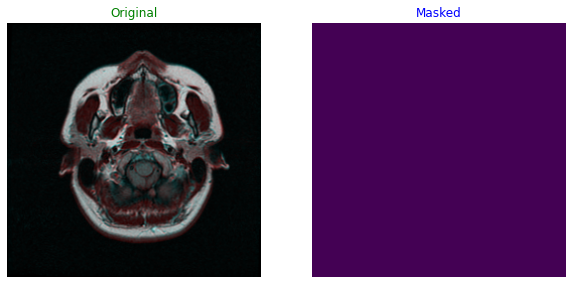

In [15]:
plot_original_mask()

### Creating train, test and val sets

In [16]:
df = pd.DataFrame({"filename":file_paths,
                   "mask":file_paths_masked})

df_train, df_test = train_test_split(df,test_size=0.1)
df_train, df_val = train_test_split(df_train,test_size=0.2)

df_train.shape, df_val.shape, df_test.shape

((2836, 2), (709, 2), (394, 2))

In [17]:
def train_generator(data_frame, batch_size, aug_dict, image_color_mode="rgb", 
                    mask_color_mode="grayscale", image_save_prefix="image", mask_save_prefix="mask", 
                    save_to_dir=None, target_size=(256,256), seed=1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_gen = zip(image_generator,mask_generator)
    
    for (img, mask) in train_gen:
      img , mask = adjust_data(img,mask)
      yield (img,mask)
        
def adjust_data(img,mask):
  img = img/255
  mask = mask/255
  mask[mask>0.5] = 1
  mask[mask<=0.5] = 0
        
  return (img,mask)

# Modelization

In [18]:
def dice_coef(y_true,y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    cal=K.sum(y_truef*y_predf)
    
    return ((2*cal+100)/(K.sum(y_truef)+K.sum(y_predf)+100))

def dice_coef_loss(y_true,y_pred):
    return -dice_coef(y_true,y_pred)

def iou(y_true,y_pred):
    intersection = K.sum(y_true*y_pred)
    sum_ = K.sum(y_true+y_pred)
    jac = (intersection+100)/(sum_-intersection+100)
    return jac

def jac_distance(y_true,y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    
    return -iou(y_true,y_pred)

In [19]:
def unet(input_size=(256,256,3)):
    inputs = layers.Input(input_size)
    
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = layers.BatchNormalization(axis=3)(conv1)
    bn1 = layers.Activation('relu')(bn1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = layers.Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = layers.BatchNormalization(axis=3)(conv2)
    bn2 = layers.Activation('relu')(bn2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = layers.Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = layers.BatchNormalization(axis=3)(conv3)
    bn3 = layers.Activation('relu')(bn3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = layers.Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = layers.BatchNormalization(axis=3)(conv4)
    bn4 = layers.Activation('relu')(bn4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = layers.BatchNormalization(axis=3)(conv5)
    bn5 = layers.Activation('relu')(bn5)

    up6 = layers.concatenate([layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = layers.BatchNormalization(axis=3)(conv6)
    bn6 = layers.Activation('relu')(bn6)

    up7 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = layers.BatchNormalization(axis=3)(conv7)
    bn7 = layers.Activation('relu')(bn7)

    up8 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = layers.Activation('relu')(conv8)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = layers.BatchNormalization(axis=3)(conv8)
    bn8 = layers.Activation('relu')(bn8)

    up9 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = layers.Activation('relu')(conv9)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = layers.BatchNormalization(axis=3)(conv9)
    bn9 = layers.Activation('relu')(bn9)

    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return models.Model(inputs=[inputs], outputs=[conv10])

In [20]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [21]:
EPOCHS = 5
BATCH_SIZE = 64
learning_rate = 1e-4
decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

In [1]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                            train_generator_args,
                            target_size=(256, 256))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                             dict(),
                             target_size=(256, 256))
    
model = unet(input_size=(256, 256, 3))

model.compile(optimizer=opt, 
              loss=dice_coef_loss, 
              metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('/content/drive/MyDrive/computer-vision/project/', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

# Predictions with Model

In [22]:
# Loading the trained and downloaded model from the cloud
load_model = tf.keras.models.load_model("/content/drive/MyDrive/computer-vision/project/model/unet_brain_mri_seg.hdf5", 
                                        custom_objects={'dice_coef_loss': dice_coef_loss, 
                                                                                   'iou': iou, 
                                                                                   'dice_coef': dice_coef})
load_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 activation_18 (Activation)     (None, 256, 256, 64  0           ['conv2d_19[0][0]']              
                                )                                                           

In [23]:
# Generating test paths
test_filepaths = list(df_test["filename"])
test_mask_filepaths = list(df_test["mask"])
len(test_filepaths), len(test_mask_filepaths)

(394, 394)

(-0.5, 255.5, 255.5, -0.5)

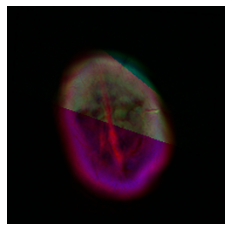

In [24]:
plt.axis(False);

img = io.imread(file_paths[444])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = io.imread(file_paths_masked[444])

img[mask == 255] = (255, 0, 0)
plt.imshow(img)
plt.axis(False)

# Plotting Predictions

In [25]:
# To plot our predictions
def plot_random_preds():
    plt.figure(figsize=(17, 10))
    rand_arr = random.sample(range(len(test_filepaths)), 3)
    i_ = 0
    for i in range(0, 11, 5):
        # getting the images
        img = io.imread(test_filepaths[rand_arr[i_]])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        true_mask = io.imread(test_mask_filepaths[rand_arr[i_]])
        
        # making predictions
        pred_mask = load_model.predict(tf.expand_dims(img, axis=0)/255)
        pred_mask = pred_mask[np.newaxis, :, :, :]
        pred_mask = np.squeeze(pred_mask) > .5

        # Plotting the images
        plt.subplot(3, 5, i+1)
        plt.axis(False)
        plt.title("Image", color="blue")
        plt.imshow(img)
        
        # To plot original image
        plt.subplot(3, 5, i+2)
        plt.axis(False)
        plt.title("True Mask", color="green")
        plt.imshow(true_mask)
        
        # To plot pred 
        plt.subplot(3, 5, i+3)
        plt.axis(False)
        plt.title("Pred Mask", color="red")
        plt.imshow(pred_mask)
        
        # To plot orig mask on image
        img[true_mask == 255] = (0, 255, 0)
        plt.subplot(3, 5, i+4)
        plt.axis(False)
        plt.title("True Mask", color="green")
        plt.imshow(img)
        
        # To plot pred mask on image 
        img_ = io.imread(test_filepaths[rand_arr[i_]])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred_mask == 1] = (255, 0, 0)
        plt.subplot(3, 5, i+5)
        plt.axis(False)
        plt.title("Pred Mask", color="red")
        i_ += 1
        plt.imshow(img_)

1/1 [==============================] - 2s 2s/step


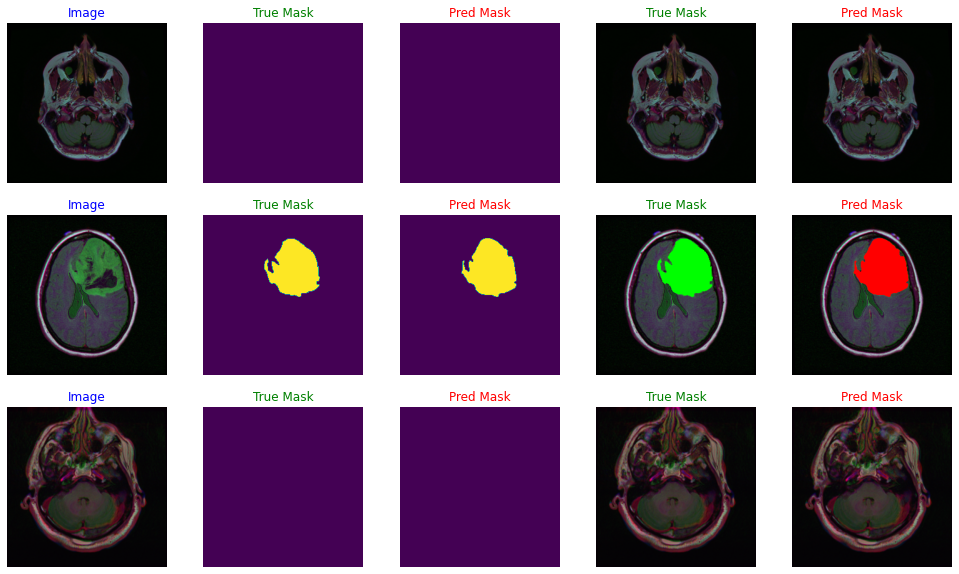

In [26]:
# Plotting random preds from test
plot_random_preds()

# Some More Plots

1/1 [==============================] - 2s 2s/step


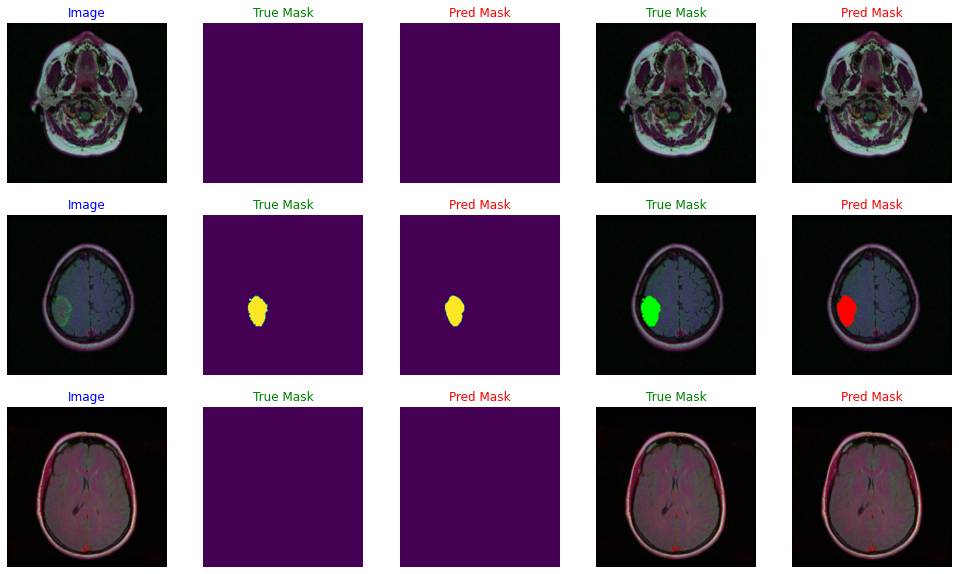

In [27]:
# Plotting random preds from test
plot_random_preds()